In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="nn_constrained.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76af06bc753d006f8a8434a46e6f404e NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))

In [4]:
data_refpoints = dict(Nobs=np.shape(Y)[-1], 
                      in_dim=2, 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=100,
                      y=Y)

#### Run Stan:

In [5]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints_lle = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=500, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints_lle);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


525.82 minutes to run
Inference for Stan model: anon_model_76af06bc753d006f8a8434a46e6f404e.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]               -0.13    0.41   0.82   -1.0   -0.9  -0.49   0.89   0.99      4  12.85
X[2,1]               -0.04    0.38   0.76   -1.0  -0.87   0.01   0.67   0.98      4  19.62
X[3,1]                0.32    0.37   0.75  -0.93  -0.46   0.72   0.99    1.0      4  20.59
X[4,1]               -0.16    0.33   0.67   -1.0  -0.88  -0.23    0.4    1.0      4   8.57
X[5,1]               -0.17     0.4    0.8   -1.0   -0.9  -0.54   0.78   0.98      4  11.99
X[6,1]                0.09    0.23   0.47  -0.73  -0.33   0.16   0.45   0.83      4   5.14
X[7,1]                0.38     0.3   0.61  -0.82  -0.08    0.6   0.95    1.0      4  10.44
X[8,1]               -0.19    0.27   0.55  -0.89   -0.7  -0.29  

In [6]:
trace = fit_refpoints_lle.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

### Traceplots of some latent variables:

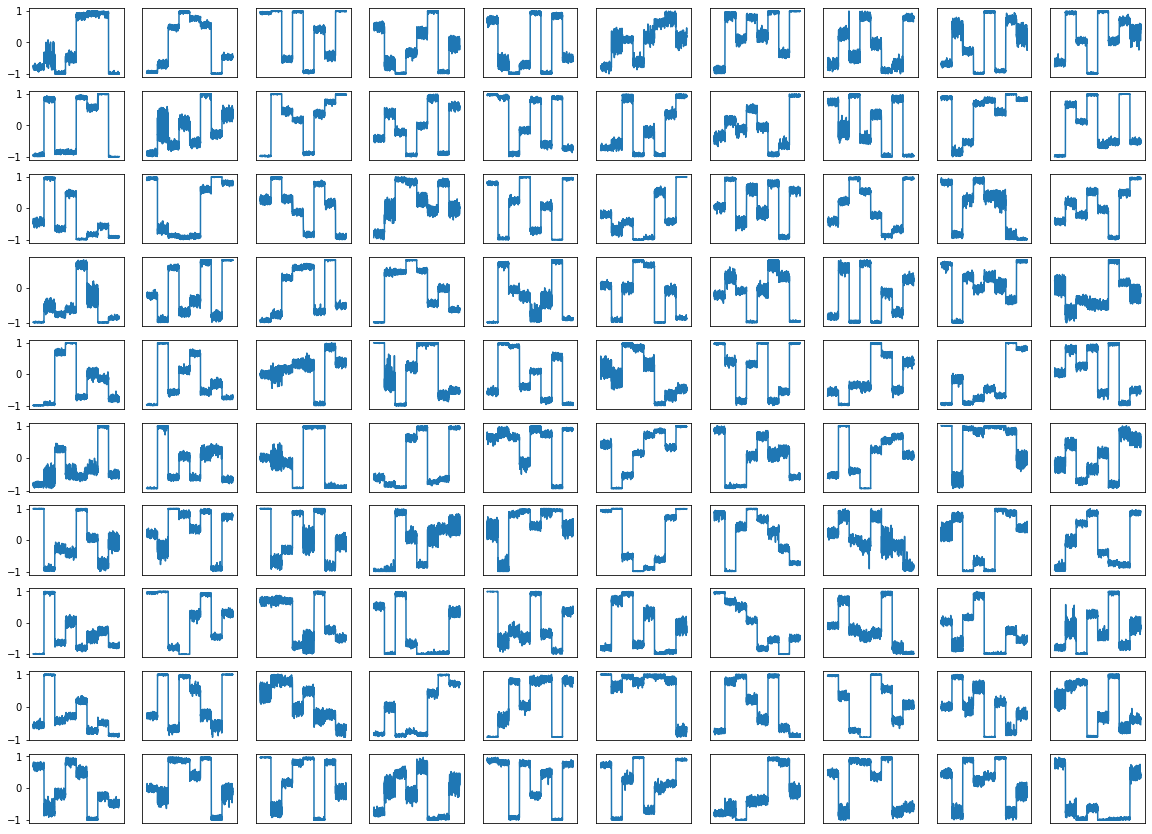

In [8]:
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['X'][:,k,0])
        if j > 0 : 
            plt.yticks([])
        plt.xticks([])
plt.show()

### Loss:

In [9]:
def L2_loss(Y, X, weights_1, bias_1, weights_2, bias_2) :
    Y_pred = np.matmul(np.tanh(np.matmul(X,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((Y-Y_pred)**2,axis=1))

100%|██████████| 2000/2000 [00:02<00:00, 678.45it/s]


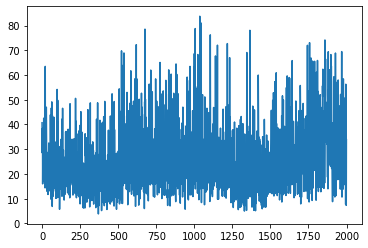

In [11]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y.transpose(), trace['X'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i]) \
                #/ trace_lle['error_sigma2'][i]
plt.plot(loss)

### Pairwise distances:

In [14]:
idx = npr.choice(np.shape(trace['X'])[1],10,replace=False)
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,idx[i]]-
                                                       trace['X'][k,idx[j]])

100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


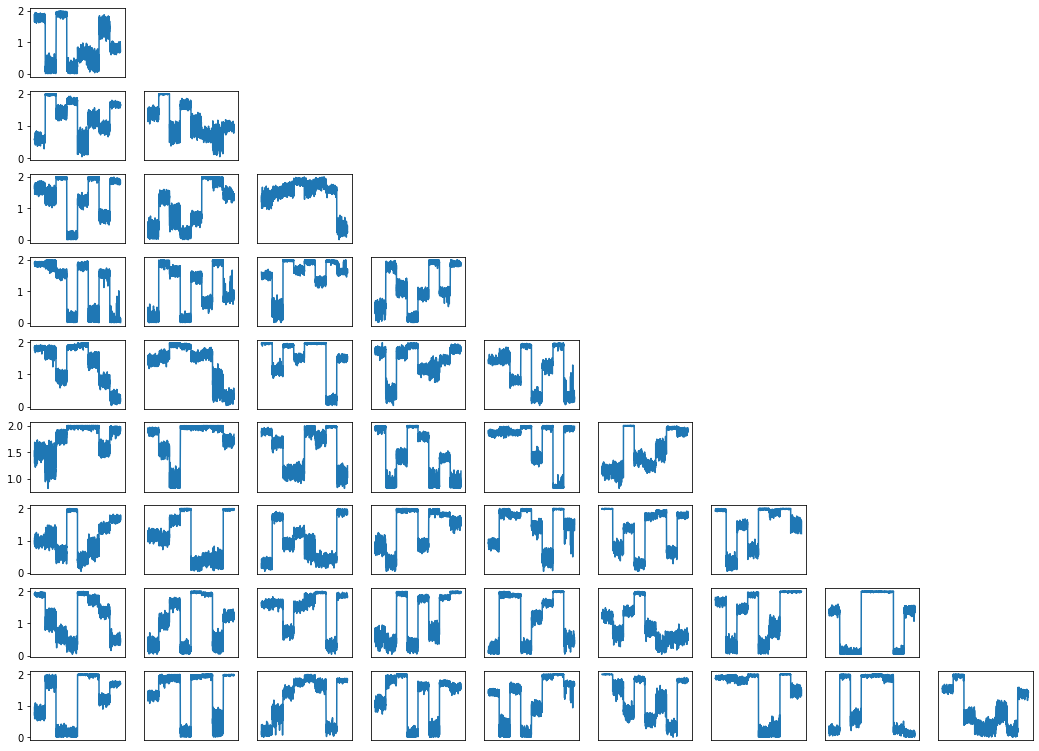

In [16]:
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            plt.subplot(10,10,10*i+j+1)
            plt.plot(pw_dist_matrix[i,j])
            plt.xticks([])
            if j > 0 :
                plt.yticks([])
plt.show()